This notebook reads in unwrapped igrams from tip of Laguna Salada and plots time series with them

This notebook: <br>
1. Reads in unwrapped igrams (210 of them), stores them in 3D array. Each slice is a single igram, first dimension is dates/time 
2. Removes phase from a single reference point  
3. Plots a single igram to test. Can plot points of reference + interest too
4. Extract time series at X by X points in LS, plots them in radians. 
5. for 100x100 pixels above, at each time takes the 1sigma above median and 1sigma below median and plots them as the time series that captures 68% of variability 


This notebook was written on 12-02-22

***

Things to do::

1. Make the time series relative to a point in open desert that is close enough to not have atm. differences than in LS and less chance of unwrapping errors: does that look the same as the time series I did with top left subtracted and then the 2 points differenced? <br>
__DONE__
2. Make time series for groups of pixels rather than just an average over a small area. Do they all look the same as the one I had gotten before? <br>
__DONE__
3. Look at the igrams in the first 1-2 years of time series, is the super fast uplift really occuring? Could be salt growth.<br>

4. Make sure I know if positive is uplift or subsidence<br>
__negative is ground moving up__
5. Keep time series of disp. in radians and add lines of 2pi intervals to check for unwrapping errors.

X. Later: unwrap region around Cerro Prieto <br>
X. Later: unwrap region around the TPC anomaly area, what's going on there? 


In [1]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib  widget

Define directory where igrams are sitting. Define directory where we can pull out the dates to loop through. Define size of files to be read in.

In [2]:
# igramsDir is where the cropped, unwrapped igrams are 
igramsDir = '/data/ocp4/LagunaSalada/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/'
# this one is to pick out the dates 
datesDir = '/data/ocp4/LagunaSalada/cropped_9000_1800_18000_3600/'

dx = 3000
dy = 750

Load in the dates to loop through and print out the number of interferograms we have.

In [3]:
# load in dates, make sure they are in order
dates = [os.path.basename(x) for x in glob.glob(datesDir+"SLC_vv/2*")]; dates = sorted(dates)
nd = len(dates); numIgrams = nd-1
print(str(numIgrams)+' igrams.')

210 igrams.


Load in the igrams into a 3D array. 

In [4]:
# make an array to hold igrams
igrams = np.ndarray((numIgrams,dy,dx),dtype='float')
for i in range(numIgrams):
    # define the 2 dates. 
    date1=dates[i]; date2=dates[i+1]
    # Read in the igram 
    ds = gdal.Open(igramsDir+date1+"_"+date2+"_filt_unwr.int", gdal.GA_ReadOnly)
    #ds = gdal.Open(igramsDir+date1+"_"+date2+"_unwr.int", gdal.GA_ReadOnly)
    igrams[i] = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
print('igrams loaded.')

igrams loaded.


Remove the value at a reference point for each igram. Then, only need to calculate single time series in LS that is relative to this point.

In [37]:
refpoint = [500,2500] # ref point as open desert 
#refpoint = [0,2999] # ref point as upper left corner pixel 
comparepoint = [500,1000]

refpoint = [645,2000] # new open desert pixel 
comparepoint = [645,1000]

In [38]:
# remove the phase value at the reference point 

# initialize an array for corrected igrams 
igramsCor = np.ndarray(np.shape(igrams),dtype='float')

for i in range(numIgrams):
    # remove the value at point (500,2500) which is in open desert
    igramsCor[i] = igrams[i]-igrams[i,refpoint[0],refpoint[1]]
    # can use a different point (?,?) as reference
print('igrams corrected by subtracting value at a reference point in open desert.')

igrams corrected by subtracting value at a reference point in open desert.


Plot a single igram that we've now loaded in. 

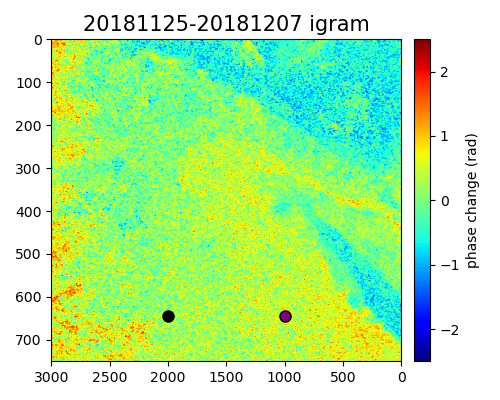

In [39]:
i = 46; date1=dates[i]; date2=dates[i+1]
plt.figure(figsize=(5,4),tight_layout=True) # for poster: figsize=(72/12+1,65/12)
ax = plt.axes()
im = plt.imshow(igramsCor[i],aspect='auto',interpolation='nearest',extent=[0,dx,dy,0],vmin=-2.5,vmax=2.5)
plt.colorbar(orientation='vertical',pad=0.03,label='phase change (rad)'); plt.set_cmap('jet')
ax.ylabel_style = {'size': 15, 'color': 'black'}; ax.xlabel_style = {'size': 15, 'color': 'black'}
ax.set_xlim([dx,0]); ax.set_ylim([dy,0])
plt.title(str(date1)+'-'+str(date2)+' igram',fontsize=15)
#plt.xlabel('range'); plt.ylabel('azimuth')

# plot a box over the area I'll be averaging to remove 
# avgAreaY = [0,0,avgY,avgY,0]
# avgAreaX = [dx,dx-avgX,dx-avgX,dx,dx]; 
# plt.plot(avgAreaX,avgAreaY,'k-')
plt.plot(comparepoint[1],comparepoint[0],'o',color='purple',markersize=8,mec='k')
plt.plot(refpoint[1],refpoint[0],'o',color='k',markersize=8,mec='k')
#plt.xticks([]); plt.yticks([])
plt.show()
#saveAs = 'igram_'+str(date1)+'_'+str(date2)+'.png'
#plt.savefig(saveAs, transparent=True)

Calculate the time of each igram (time btw sequential SLCs) in number of days. Pull out dates as datetime objects, then calculate the difference between each sequential slc, then convert the timedelta objects to number of days. 

In [40]:
# dates is a list of strings, convert strings to datetime objects 
slc_dates=[]
for i in range(0,len(dates)):
    slc_dates.append(datetime.strptime(str(dates[i]).replace('\n',''), '%Y%m%d'))
# take numIgrams and pull out the igram_dates, corresponding to the first day of each igram
igram_dates = slc_dates[0:-1]
dt1 = np.diff(slc_dates) # calculate dt between slcs, these are now timedelta objects
# convert to floats 
dt = np.zeros([len(dt1),1])
for i in range(len(dt)):
    dt[i] = dt1[i].days #/365.25 # dt is now an array of floats (years btw slc acquisitions)
print('slc_dates: '+str(np.shape(slc_dates)))
print('igram_dates: '+str(np.shape(igram_dates)))
print('^datetime objects now')
#print(dt)

slc_dates: (211,)
igram_dates: (210,)
^datetime objects now


Extract a time series at a point in LS relative to the reference point that is in open desert. Plot the time series in radians/igram to start.

In [41]:
# initialize arrays to hold time series for each point
dim_pixel_range = 100
num_pixels = int(dim_pixel_range**2)

disp_rates = np.zeros((numIgrams,num_pixels),dtype='float')
count = 0
# these are rates in (radians/igram interval)
for j in range(dim_pixel_range):
    for k in range(dim_pixel_range):
        #print('j: '+str(j)+'  k: '+str(k)+'  count: '+str(count))
        #disp_rates[:,count] = igramsCor[:,comparepoint[0]+j,comparepoint[1]+k]
        disp_rates[:,count] = igramsCor[:,comparepoint[0]+j,comparepoint[1]+k] - igramsCor[:,refpoint[0]+j,refpoint[1]+k]
        #print(disp_rates[110:120,count])
        count += 1
# calculate cumulative displacement in radians 
cum_disps = np.cumsum(disp_rates,axis=0) # this and next are cumulative disp in (rad)

Load in precip data and gather the dates of the storms that had >some threshold value of precipitation. Put those dates into a list for plotting later.

In [42]:
# Read in 2day precipitation data
precip = np.loadtxt('/data/ocp4/LagunaSalada/3_precip/precip_2days.txt', dtype='float')
#precip = np.loadtxt('/data/ocp4/LagunaSalada/3_precip/precip_cumulative.txt', dtype='float')

# BIGGER STORMS
# days with precip > 0.3cm 
print('i \tdate \t\t       precip > 0.3cm')
#print('i \tdate \t\t       precip > 0.0cm')
rain_dates = []
for i in np.arange(len(precip)): 
    if precip[i] > 0.3:
        print(str(i)+'\t'+str(slc_dates[i])+'    '+str(precip[i])+' cm')
        rain_dates.append(slc_dates[i])

i 	date 		       precip > 0.3cm
0	2017-05-10 00:00:00    0.33020000000000005 cm
47	2018-12-07 00:00:00    5.0546 cm
74	2019-09-27 00:00:00    1.4478 cm
83	2019-11-20 00:00:00    2.286 cm
97	2020-02-12 00:00:00    1.1684 cm
102	2020-03-13 00:00:00    0.40640000000000004 cm
107	2020-04-12 00:00:00    0.9906 cm
186	2021-08-11 00:00:00    0.381 cm


Plot all the time series at LS and in open desert (in radians). Don't run this if I've calculated a time series for 10,000 pixels: takes a long time to plot. 

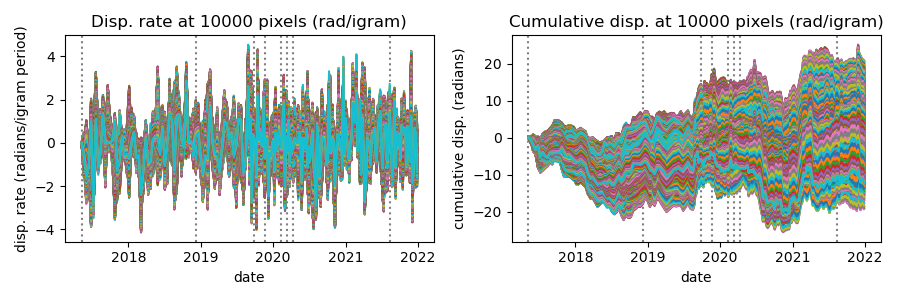

In [11]:
plt.figure(figsize=(9,3),tight_layout='TRUE')
plt.subplot(1,2,1)
for i in range(num_pixels):
    plot_label = str('pixel '+str(i))
    plt.plot(igram_dates,disp_rates[:,i],label=plot_label)

Ymin,Ymax = plt.gca().get_ylim()
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=0)
plt.ylim([Ymin,Ymax])
#plt.ylim([-0.3,0.5])
#plt.legend(); 
plt.title('Disp. rate at '+str(num_pixels)+' pixels (rad/igram)')
plt.ylabel('disp. rate (radians/igram period)'); plt.xlabel('date')

plt.subplot(1,2,2)
for i in range(num_pixels):
    plot_label = str('pixel '+str(i))
    plt.plot(igram_dates,cum_disps[:,i],label=plot_label)
Ymin,Ymax = plt.gca().get_ylim()
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=0)
plt.ylim([Ymin,Ymax])
#plt.ylim([-5,5])
#plt.legend(); 
plt.title('Cumulative disp. at '+str(num_pixels)+' pixels (rad/igram)')
plt.ylabel('cumulative disp. (radians)'); plt.xlabel('date')
plt.show()

Now out of all the time series we produced, get values for each time of 1 sigma above median and 1 sigma below median to represent the spread of the data. <br><br> **MAKE SURE that I used 10 as dim_pixel_range because we need exactly 100 pixels for this to work**

In [43]:
# calculate time series for one standard deviation above median, one below median 
upper = np.zeros((len(igram_dates),)); upper_cum = np.zeros((len(igram_dates),))
lower = np.zeros((len(igram_dates),)); lower_cum = np.zeros((len(igram_dates),))
single_date_disps = np.zeros((num_pixels,)) # MAKE SURE THIS IS 100 FOR THIS TO WORK 
single_date_cum_disps = np.zeros((num_pixels,))
# loop through each igram date
for i in range(len(igram_dates)): #len(igram_dates)
    # sort the values 
    single_date_disps = sorted(disp_rates[i,:])
    #print(single_date_disps[0],single_date_disps[-1])
    upper[i] = single_date_disps[330]
    lower[i] = single_date_disps[830]
    single_date_cum_disps = sorted(cum_disps[i,:])
    upper_cum[i] = single_date_cum_disps[330]
    lower_cum[i] = single_date_cum_disps[830]
#print(np.shape(disp_rates))
#print(np.shape(cum_disps))

Plot the 1sigma above and 1sigma below mean value for each date as time series

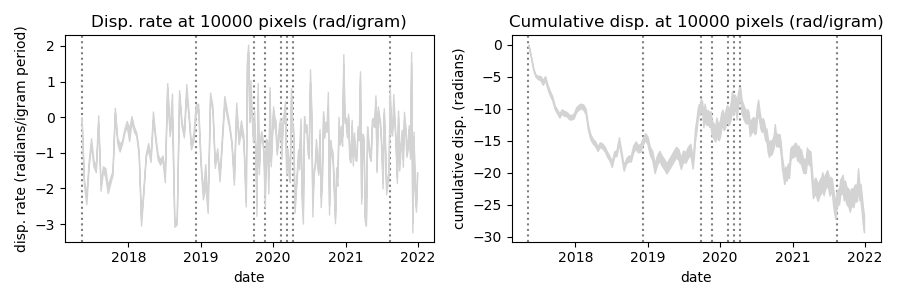

In [44]:
plt.figure(figsize=(9,3),tight_layout='TRUE')
plt.subplot(1,2,1)
#plt.plot(igram_dates,upper,label='1 \u03C3 above median')
#plt.plot(igram_dates,lower,label='1 \u03C3 below median')
plt.fill_between(igram_dates,lower,upper,color='lightgray')
Ymin,Ymax = plt.gca().get_ylim()
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=0)
plt.ylim([Ymin,Ymax])
#plt.legend(); 
plt.title('Disp. rate at '+str(num_pixels)+' pixels (rad/igram)')
plt.ylabel('disp. rate (radians/igram period)'); plt.xlabel('date')

plt.subplot(1,2,2)
#plt.plot(igram_dates,upper_cum,label='1 \u03C3 above median')
#plt.plot(igram_dates,lower_cum,label='1 \u03C3 below median')
plt.fill_between(igram_dates,lower_cum,upper_cum,color='lightgray')
Ymin,Ymax = plt.gca().get_ylim()
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=0)
plt.ylim([Ymin,Ymax])
#plt.ylim([-5,5])
#plt.legend(); 
plt.title('Cumulative disp. at '+str(num_pixels)+' pixels (rad/igram)')
plt.ylabel('cumulative disp. (radians)'); plt.xlabel('date')
plt.show()

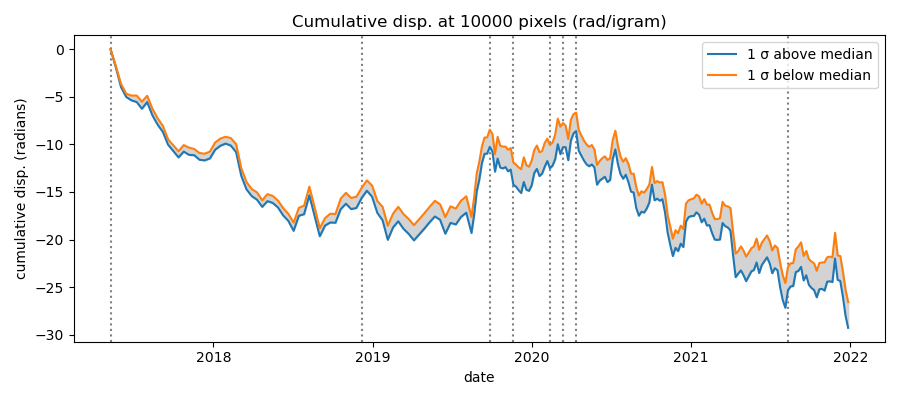

In [45]:
# plot the cumulative disps larger for finer detail 
plt.figure(figsize=(9,4),tight_layout='TRUE')
plt.plot(igram_dates,upper_cum,label='1 \u03C3 above median')
plt.plot(igram_dates,lower_cum,label='1 \u03C3 below median')
plt.fill_between(igram_dates,lower_cum,upper_cum,color='lightgray')
Ymin,Ymax = plt.gca().get_ylim()
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=0)
plt.ylim([Ymin,Ymax])
plt.legend(); 
plt.title('Cumulative disp. at '+str(num_pixels)+' pixels (rad/igram)')
plt.ylabel('cumulative disp. (radians)'); plt.xlabel('date')
plt.show()

# ADD 2PI lines HERE. I DID THIS SOMEWHERE ELSE, FIND THE CODE

Convert radians/igram period to cm/yr rates using radians --> cm and igram --> dt

In [ ]:
# make a conversion factor from radians to cm 
wavelength = 5.5465763
rad2cm = wavelength/(4*np.pi) # this is conversion factor that I multiply by the data (which is in rads)

disp_rate_LS_cmYr = disp_rate_LS*rad2cm/dt.reshape((numIgrams,)) # this and next are rates in (cm/yr)
#disp_rate_desert_cmYr = disp_rate_desert*rad2cm/dt.reshape((numIgrams,))

cum_disp_LS_cm = np.cumsum(disp_rate_LS*rad2cm) # this and next are cumulative disp in (cm)
#cum_disp_desert_cm = np.cumsum(disp_rate_desert*rad2cm)

Plot the converted time series (in cm now)

In [ ]:
plt.figure(figsize=(9,3),tight_layout='TRUE')
plt.subplot(1,2,1)
#plt.plot(igram_dates,disp_rate_desert_cmYr,'darkorange',label='open desert',zorder=3)
plt.plot(igram_dates,disp_rate_LS_cmYr,'purple',label='Laguna Salada',zorder=10)
Ymin,Ymax = plt.gca().get_ylim()
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=0)
plt.ylim([Ymin,Ymax])
plt.legend(); plt.title('Disp. rate at 2 points (cm/yr)')
plt.ylabel('disp. rate (cm/yr)'); plt.xlabel('date')
plt.subplot(1,2,2)
#plt.plot(igram_dates,cum_disp_desert_cm,'darkorange',label='open desert',zorder=3)
plt.plot(igram_dates,cum_disp_LS_cm,'purple',label='Laguna Salada',zorder=10)
Ymin,Ymax = plt.gca().get_ylim()
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=0)
plt.ylim([Ymin,Ymax])
plt.legend(); plt.title('Cumulative disp. at 2 points (cm)')
plt.ylabel('cumulative disp. (cm)'); plt.xlabel('date')
plt.show()

In [ ]:
plt.figure(figsize=(6,2.5),tight_layout='TRUE')
#plt.plot(igram_dates,cum_disp_desert_cm,'darkorange',label='open desert',zorder=3)
plt.plot(igram_dates,cum_disp_LS_cm,'purple',label='Laguna Salada',zorder=10)
Ymin,Ymax = plt.gca().get_ylim()
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=0)
plt.ylim([Ymin,Ymax])
plt.legend(); #plt.title('Cumulative disp. at 2 points (cm)')
plt.ylabel('cumulative disp. (cm)'); plt.xlabel('date')
plt.show()
#plt.savefig("cum_disp_filt.png", transparent=True)

Make a plot showing the difference between the two (displacement relative to each other)

In [ ]:
plt.figure(figsize=(6,3),tight_layout='TRUE')
plt.plot(igram_dates,cum_disp_LS_cm-cum_disp_desert_cm,'blue',zorder=3)
Ymin,Ymax = plt.gca().get_ylim()
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=0)
plt.ylim([Ymin,Ymax])
plt.title('Disp. between the 2 points (cm)')
plt.ylabel('cumulative disp.(cm/)'); #plt.xlabel('date')
plt.show()

#plt.savefig("disp_btw_pts.png",transparent=True)

Now calculate an average displacement rate for each pixel in my region. Extract time series at one pixel at a time, convert it to cm and do cumulative sum, then fit a line to it (first try entire time series, then try just up through 2019 like Jiang and Lohman, 2021), then put the rate (slope of the best-fit line) into an array and plot the array.

In [ ]:
# initialize arrays to hold time series for each point
disp_rates_temp = np.ndarray((numIgrams,),dtype='float')
cum_disp_temp_cm = np.ndarray((numIgrams,),dtype='float')
avg_disp_rates = np.ndarray((dy,dx),dtype='float') 
# make a conversion factor from radians to cm 
wavelength = 5.5465763
rad2cm = wavelength/(4*np.pi) # this is conversion factor that I multiply by the data (which is in rads)
# need to convert igram_dates to number of days/years to fit a line with them
igram_dates_floatyrs = np.ndarray(np.shape(igram_dates),dtype='float')
for i in range(numIgrams):
    igram_dates_floatyrs[i] = (igram_dates[i]-igram_dates[0]).days/365.25

# loop through pixels 
for y in range(dy):
    for x in range(dx):
        # pull out time series at the pixel 
        disp_rates_temp = igramsCor[:,y,x] 
        # convert it to cm and cumulative sum it 
        cum_disp_temp_cm = np.cumsum(disp_rates_temp*rad2cm)
        # now fit a line to this. m is slope, b is intercept
        m, b = np.polyfit(igram_dates_floatyrs, cum_disp_temp_cm, 1)
        # put that rate into the avg_disp_rates array 
        avg_disp_rates[y,x] = m

Now plot the average rates over the entire area

In [ ]:
plt.figure(figsize=(72/12+1,65/12),tight_layout=True)
ax = plt.axes()
#im = plt.pcolor(igramsCor[i])
im = plt.imshow(avg_disp_rates, aspect='auto', vmin=-8, vmax=8, \
                interpolation='nearest', extent = [0,dx,dy,0])
plt.colorbar(orientation='vertical',pad=0.03,label='disp rate (cm/yr)')
plt.set_cmap('seismic')
ax.ylabel_style = {'size': 15, 'color': 'black'}
ax.xlabel_style = {'size': 15, 'color': 'black'}
ax.set_xlim([dx,0]); ax.set_ylim([dy,0])
#plt.title('Average disp rates from filt igrams',fontsize=15)
#plt.xlabel('range'); plt.ylabel('azimuth')
plt.xticks([]); plt.yticks([])
plt.show()

#plt.savefig("disp_rates.png", transparent=True)